In [0]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

In [0]:
import torch 
import torchvision
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import os
from PIL import Image
import glob
import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw
import matplotlib.pyplot as plt
import random
from bokeh.io import curdoc, show, output_notebook
from bokeh.layouts import column
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from functools import partial
from threading import Thread
from tornado import gen
import time
import pickle
from tqdm import tqdm
import torchvision.utils as vutils


#root folder
root_dir="/content/drive/My Drive/Fall 2019/Deep Learning CSE 676/Projects/1/DC Gans/"

#data directories
#output images
output_dir=root_dir+"output/epoch/"
#input images
input_dir=root_dir+"data/augmented/"

#log dir
log_dir=root_dir+"logs/"

#models
model_dir=root_dir+"model/"
#other resources
res_dir=root_dir+"res/"
#report and logging
report_dir=root_dir+"report/"


#parameters
batch_size=100
train_split=0.8
train_epoch=50

#input
data_dir="data"
inp_width=32
inp_height=32
inp_channels=3
nc=3
nz=200

#generator
ngf=64
ndf=64

#discriminator
ndf=2

Importing logger to keep a track of training progress 

##utils

In [0]:

import itertools, imageio, torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
#from scipy.misc import imresize
#import PIL
#import pilutil


def ones_target(size):
  #returning tensor variable containing ones, with shape =size
  data=Variable(torch.ones(size,1))
  return data

def zeros_target(size):
  data=Variable(torch.zeros(size,1))
  return data

def images_to_vectors(images):
  return images.view(images.size(0),3072) #parameters: (size to flatten(28 here, row size), no. of images to be flattened)

def vectors_to_images(vectors):
  return vectors.view(vectors.size(0),3,32,32) # to convert each row of vectors to 28x28 pixels images 
# parameteres: (initial flattened dim, no. of sub vectors to be converted to 2d, 2d dimensions of output )

def show_result(G, x_, num_epoch, show = False, save = False, path = 'result.png'):
    # G.eval()
    y_ = G(x_)
    y_=y_[:4]
    y_ = y_.cpu()

    size_figure_grid = 3
    fig, ax = plt.subplots(x_.size()[0], size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(x_.size()[0]), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for i in range(y_.size()[0],2):

        ax[i, 0].cla()
        ax[i, 0].imshow((y_[i].numpy().transpose(1, 2, 0) + 1) / 2)
        ax[i, 1].cla()
        ax[i, 1].imshow((y_[i+1].numpy().transpose(1, 2, 0) + 1) / 2)

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

def generate_animation(root, model, opt):
    images = []
    for e in range(opt.train_epoch):
        img_name = root + 'Fixed_results/' + model + str(e + 1) + '.png'
        images.append(imageio.imread(img_name))
    imageio.mimsave(root + model + 'generate_animation.gif', images, fps=5)

def data_load(path, subfolder, transform, batch_size, shuffle=True):
    dset = datasets.ImageFolder(path, transform)
    ind = dset.class_to_idx[subfolder]

    n = 0
    for i in range(dset.__len__()):
        if ind != dset.imgs[n][1]:
            del dset.imgs[n]
            n -= 1

        n += 1

    return torch.utils.data.DataLoader(dset, batch_size=batch_size, shuffle=shuffle)

def imgs_resize(imgs, resize_scale = 286):
    outputs = torch.FloatTensor(imgs.size()[0], imgs.size()[1], resize_scale, resize_scale)
    for i in range(imgs.size()[0]):
        img = imresize(imgs[i].numpy(), [resize_scale, resize_scale])
        outputs[i] = torch.FloatTensor((img.transpose(2, 0, 1).astype(np.float32).reshape(-1, imgs.size()[1], resize_scale, resize_scale) - 127.5) / 127.5)

    return outputs

def random_crop(imgs1, imgs2, crop_size = 256):
    outputs1 = torch.FloatTensor(imgs1.size()[0], imgs1.size()[1], crop_size, crop_size)
    outputs2 = torch.FloatTensor(imgs2.size()[0], imgs2.size()[1], crop_size, crop_size)
    for i in range(imgs1.size()[0]):
        img1 = imgs1[i]
        img2 = imgs2[i]
        rand1 = np.random.randint(0, imgs1.size()[2] - crop_size)
        rand2 = np.random.randint(0, imgs2.size()[2] - crop_size)
        outputs1[i] = img1[:, rand1: crop_size + rand1, rand2: crop_size + rand2]
        outputs2[i] = img2[:, rand1: crop_size + rand1, rand2: crop_size + rand2]

    return outputs1, outputs2

def random_fliplr(imgs1, imgs2):
    outputs1 = torch.FloatTensor(imgs1.size())
    outputs2 = torch.FloatTensor(imgs2.size())
    for i in range(imgs1.size()[0]):
        if torch.rand(1)[0] < 0.5:
            img1 = torch.FloatTensor(
                (np.fliplr(imgs1[i].numpy().transpose(1, 2, 0)).transpose(2, 0, 1).reshape(-1, imgs1.size()[1], imgs1.size()[2], imgs1.size()[3]) + 1) / 2)
            outputs1[i] = (img1 - 0.5) / 0.5
            img2 = torch.FloatTensor(
                (np.fliplr(imgs2[i].numpy().transpose(1, 2, 0)).transpose(2, 0, 1).reshape(-1, imgs2.size()[1], imgs2.size()[2], imgs2.size()[3]) + 1) / 2)
            outputs2[i] = (img2 - 0.5) / 0.5
        else:
            outputs1[i] = imgs1[i]
            outputs2[i] = imgs2[i]

    return outputs1, outputs2

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def noise(size):
  n=Variable(torch.randn(size,200))
  return n
 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
def log_tboard(numerical_info, image_info,step):

  for tag, value in numerical_info.items():
      logger.scalar_summary(tag, value, step+1)

  #for tag, images in image_info.items():
   #   logger.image_summary(tag, images, step+1)
     



##Loading the CIFAR Data

0it [00:00, ?it/s]

 98%|█████████▊| 167911424/170498071 [00:12<00:00, 16952978.87it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Size of train set 400
Size of val set 100
Size of test set 2500


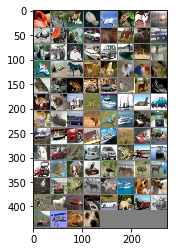

 bird  deer   dog   cat plane  frog   dog plane  bird truck   cat   car   cat horse   dog truck horse truck   dog  ship   car  ship  deer   cat plane plane horse  deer  frog   cat   dog  frog  bird   cat  frog  bird   car  bird horse  ship   dog   cat truck  deer  ship  ship plane   car   dog  ship   car  deer plane  ship   cat   car   car  ship   car   cat  ship  deer  ship  bird   cat   car  bird  ship   car  frog plane  ship   car   cat   dog   cat  bird horse  bird horse  bird  ship  frog  deer   cat plane   dog   dog plane  deer  ship   car   car   dog truck  deer   car plane   cat   dog
Size of images torch.Size([100, 3, 32, 32])


In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_size=int(train_split*len(dataset))
val_size=len(dataset)-train_size
trainset, valset=torch.utils.data.random_split(dataset,[train_size,val_size])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("Size of train set",len(trainloader))
print("Size of val set",len(valloader))
print("Size of test set",len(testloader))



# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
print("Size of images",images.size())


Adding funcionality to flatten an image and vice versa. 
Flattening means to convert a multidimensional matrix to one dimensional

##model

In [0]:
class Generator(nn.Module):
    def __init__(self, ngpu=64):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution

            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(200, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

            
    def forward(self, input):
#         if input.is_cuda and self.ngpu > 1:
#             output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
#         else:
#             output = self.main(input)
        output = self.main(input)
        return output

class Discriminator(nn.Module):
    def __init__(self, ngpu=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
#         if input.is_cuda and self.ngpu > 1:
#             output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
#         else:
#             output = self.main(input)
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

In [0]:
num_test_samples=16
#generating test samples
test_noise=noise(num_test_samples)

##Training the Gan

In [0]:
from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

In [0]:
from PIL import Image
#creating logger instance
num_epochs=50
num_batches = len(trainloader)
for epoch in range(num_epochs):
  for n_batch,(real_batch,_) in enumerate(trainloader):
    N=real_batch.size(0)
    
    #Train discriminator
    real_data=Variable(images_to_vectors(real_batch))
    #generate fake data and detach to avoid further calculation of gradients
    fake_data=generator(noise(N)).detach()
    
    #train
    d_error,d_pred_real,d_pred_fake=train_discriminator(d_optimizer, real_data, fake_data)
    
    #Train Generator
    #generate fake data
    fake_data=generator(noise(N))
    #train 
    g_error=train_generator(g_optimizer, fake_data)
    #Log batch error
    
    if(n_batch)%100==0: #??
      test_images=vectors_to_images(generator(test_noise))
      test_images=test_images.data
            
      #display status logs
      import matplotlib.pyplot as plt
      f, axarr = plt.subplots(2, 2)
      axarr[0, 0].imshow(test_images[0,0])
      axarr[0,1].imshow(test_images[1,0])
      axarr[1, 0].imshow(test_images[2,0])
      axarr[1, 1].imshow(test_images[3,0])
      # Fine-tune figure; make subplots farther from each other.
      f.subplots_adjust(hspace=0.3)

      plt.show()

In [0]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(2, 2)
axarr[0, 0].imshow(test_images[0,0])
axarr[0,1].imshow(test_images[1,0])
axarr[1, 0].imshow(test_images[2,0])
axarr[1, 1].imshow(test_images[3,0])
# Fine-tune figure; make subplots farther from each other.
f.subplots_adjust(hspace=0.3)

plt.show()


https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f

In [0]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
from torch.utils import tensorboard

##From pix2pix model

In [0]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
print(len(dataset))
train_size=int(train_split*len(dataset))
val_size=len(dataset)-train_size
train_dataset, val_dataset=torch.utils.data.random_split(dataset,[train_size,val_size])
train_dataloader=torch.utils.data.DataLoader(dataset=train_dataset, 
                                              batch_size=batch_size,
                                             shuffle=True,
                                          num_workers=4)
num_batches=len(train_dataloader)
val_dataloader=torch.utils.data.DataLoader(dataset=val_dataset,
                                             batch_size=batch_size,
                                             shuffle=True,
                                          num_workers=4)


#from model import generator, discriminator
#import utils

#parameters
lrG=0.02
lrD=0.02
beta1=0.5
beta2=0.999
L1_lambda=1.5



start_time=time.time()
epoch_start=0
epoch_end=epoch_start+train_epoch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
G = Generator(ngf)
D = Discriminator(ndf)
G_optimizer=optim.Adam(G.parameters(),lr=lrG,betas=(beta1,beta2))
D_optimizer=optim.Adam(D.parameters(),lr=lrD,betas=(beta1,beta2))
#loss

BCE_loss=nn.BCELoss().to(device)
L1_loss=nn.L1Loss().to(device)
fid_model=FID("./",device)
#fid_model.compute_fid(real_image,G_result) #todo add fid score

logger=Logger(log_dir)
#Loading the model if previously exists
if(os.path.isfile(model_dir+'generator_param.pkl') and os.path.isfile(model_dir+'discriminator_param.pkl')):

  G_checkpoint=torch.load(model_dir+'generator_param.pkl',map_location=device)
  D_checkpoint=torch.load(model_dir+'discriminator_param.pkl',map_location=device)
  G.load_state_dict(G_checkpoint['model_state_dict'])
  D.load_state_dict(D_checkpoint['model_state_dict'])
  G.to(device)
  D.to(device)
  G.train()
  D.train()
  #D.eval()

  G_optimizer.load_state_dict(G_checkpoint['optimizer_state_dict'])
  D_optimizer.load_state_dict(D_checkpoint['optimizer_state_dict'])

  train_hist=G_checkpoint['train_hist']
  epoch_start=G_checkpoint['epoch']
  epoch_end=epoch_start+train_epoch
#Esle creating new model
else:  
  print("Previous model not found. Restarting train process...")
  G.apply(weights_init)
  D.apply(weights_init)
  G.to(device)
  D.to(device)
  G.train()
  D.train()


  G_optimizer=optim.Adam(G.parameters(),lr=lrG,betas=(beta1,beta2))
  D_optimizer=optim.Adam(D.parameters(),lr=lrD,betas=(beta1,beta2))

  train_hist={}
  train_hist['D_losses']=[]
  train_hist['G_losses']=[]
  train_hist['per_epoch_ptimes']=[]
  train_hist['total_ptime']=[]
  epoch_start=0
  epoch_end=epoch_start+train_epoch

#training
for epoch in range(epoch_start,epoch_end):
  D_losses=[]
  G_losses=[]
  epoch_start_time=time.time()
  num_iter=0
  for (real_image, _) in train_dataloader:
    inp_noise=torch.randn(batch_size, nz, 1, 1, device=device)
    inp_noise,real_image=Variable(inp_noise.to(device)),Variable(real_image.to(device))
    D.zero_grad()

    D_result=D(real_image).squeeze()
    
    D_real_loss=BCE_loss(D_result,Variable(torch.ones(D_result.size()).to(device)))
    
    G_result=G(inp_noise)
    G_result=G_result.detach()
    D_result=D(G_result).squeeze()
    D_fake_loss=BCE_loss(D_result,Variable(torch.zeros(D_result.size()).to(device)))
    
    D_train_loss=(D_real_loss +D_fake_loss)*0.5
    D_train_loss.backward()
    D_optimizer.step()
    train_hist['D_losses'].append(float(D_train_loss))

    D_losses.append(float(D_train_loss))
    D_losses.append(float(0))

    #training generator
    G.zero_grad()

    G_result=G(inp_noise)
    G_result=G_result.detach()
    D_result=D(G_result).squeeze()
    G_train_loss=BCE_loss(D_result, Variable(torch.ones(D_result.size()).to(device))) + L1_lambda*L1_loss(G_result,real_image)
    G_train_loss.backward()
    G_optimizer.step()

    train_hist['G_losses'].append(float(G_train_loss))
    G_losses.append(float(G_train_loss))
    
    num_iter+=1

  torch.save({
            'epoch': epoch,
            'model_state_dict': G.state_dict(),
            'optimizer_state_dict': G_optimizer.state_dict(),
            'train_hist': train_hist
            }, model_dir+'generator_param.pkl')

  torch.save({
            'model_state_dict': D.state_dict(),
            'optimizer_state_dict': D_optimizer.state_dict(),
            },model_dir+'discriminator_param.pkl')

  epoch_end_time=time.time()
  per_epoch_ptime=epoch_end_time-epoch_start_time
  print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))
  fixed_p =  output_dir  + str(epoch + 1) + '.png'
  save_noise=torch.randn(1, nz, 1, 1, device=device)
  #show_result(G, Variable(inp_noise.to(device), volatile=True), real_image.cpu(), (epoch+1), save=True, path=fixed_p)
  vutils.save_image(G(save_noise).detach(),
                    fixed_p,
                    normalize=True)
  num_info = { 'Discriminator loss': torch.mean(torch.FloatTensor(D_losses)), 'Generator loss': torch.mean(torch.FloatTensor(G_losses)) }  
  fake_to_show=G(save_noise).detach()
  print(fake_to_show[0].size())
  image_info = { 'images': fake_to_show.cpu().numpy()}
  log_tboard(num_info,image_info,epoch)
  train_hist['per_epoch_ptimes'].append(per_epoch_ptime)
  
  

end_time=time.time()
total_ptime=end_time-start_time
train_hist['total_ptime'].append(total_ptime)
print("Avg one epoch ptime: %.2f, total %d epochs ptime: %.2f" % (torch.mean(torch.FloatTensor(train_hist['per_epoch_ptimes'])), train_epoch, total_ptime))


with open(report_dir+'train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

show_train_hist(train_hist, save=True, path=report_dir + 'train_hist.png')

Mounted at /content/drive/
50000
[53/50] - ptime: 17.22, loss_d: 1.727, loss_g: 21.382
torch.Size([3, 32, 32])
[54/50] - ptime: 17.12, loss_d: 1.727, loss_g: 21.356
torch.Size([3, 32, 32])
[55/50] - ptime: 17.29, loss_d: 1.727, loss_g: 21.306
torch.Size([3, 32, 32])
[56/50] - ptime: 17.14, loss_d: 1.727, loss_g: 21.258
torch.Size([3, 32, 32])
[57/50] - ptime: 17.10, loss_d: 1.727, loss_g: 21.249
torch.Size([3, 32, 32])
[58/50] - ptime: 17.14, loss_d: 1.727, loss_g: 21.245
torch.Size([3, 32, 32])
[59/50] - ptime: 17.29, loss_d: 1.727, loss_g: 21.221
torch.Size([3, 32, 32])


KeyboardInterrupt: ignored

In [0]:
!tensorboard --logdir=log_dir --port=6007

TensorBoard 1.15.0 at http://683152f1a078:6007/ (Press CTRL+C to quit)


##logger

In [0]:
# Code referenced from https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514
import tensorflow as tf
import numpy as np
import scipy.misc 
from PIL import Image
try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO         # Python 3.x


class Logger(object):
    
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

    def image_summary(self, tag, images, step):
        """Log a list of images."""

        img_summaries = []
        for i, img in enumerate(images):
            # Write the image to a string
            try:
                s = StringIO()
            except:
                s = BytesIO()
            print(img.size)
            Image.fromarray(img).save(s, format="png")

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=img_summaries)
        self.writer.add_summary(summary, step)
        
    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values**2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()

##fid score 

In [0]:
import math
import os
import warnings
import numpy as np
from scipy import linalg
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from tqdm import tqdm_notebook as tqdm

class FID():
    def __init__(self, cache_dir, device='cpu', transform_input=True):
        #cuda:0
        os.environ["TORCH_HOME"] = "./Cache"
        self.device=device
        self.transform_input = transform_input
        self.InceptionV3 = models.inception_v3(pretrained=True, transform_input=False, aux_logits=False).to(device=self.device)
        self.InceptionV3.eval()
    
    def build_maps(self, x):
        # Resize to Fit InceptionV3
        if list(x.shape[-2:]) != [299,299]:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                x = F.interpolate(x, size=[299,299], mode='bilinear')
        # Transform Input to InceptionV3 Standards
        if self.transform_input:
            x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
            x = torch.cat((x_ch0, x_ch1, x_ch2), 1)
        # Run Through Partial InceptionV3 Model
        with torch.no_grad():
            # N x 3 x 299 x 299
            x = self.InceptionV3.Conv2d_1a_3x3(x)
            # N x 32 x 149 x 149
            x = self.InceptionV3.Conv2d_2a_3x3(x)
            # N x 32 x 147 x 147
            x = self.InceptionV3.Conv2d_2b_3x3(x)
            # N x 64 x 147 x 147
            x = F.max_pool2d(x, kernel_size=3, stride=2)
            # N x 64 x 73 x 73
            x = self.InceptionV3.Conv2d_3b_1x1(x)
            # N x 80 x 73 x 73
            x = self.InceptionV3.Conv2d_4a_3x3(x)
            # N x 192 x 71 x 71
            x = F.max_pool2d(x, kernel_size=3, stride=2)
            # N x 192 x 35 x 35
            x = self.InceptionV3.Mixed_5b(x)
            # N x 256 x 35 x 35
            x = self.InceptionV3.Mixed_5c(x)
            # N x 288 x 35 x 35
            x = self.InceptionV3.Mixed_5d(x)
            # N x 288 x 35 x 35
            x = self.InceptionV3.Mixed_6a(x)
            # N x 768 x 17 x 17
            x = self.InceptionV3.Mixed_6b(x)
            # N x 768 x 17 x 17
            x = self.InceptionV3.Mixed_6c(x)
            # N x 768 x 17 x 17
            x = self.InceptionV3.Mixed_6d(x)
            # N x 768 x 17 x 17
            x = self.InceptionV3.Mixed_6e(x)
            # N x 768 x 17 x 17
            x = self.InceptionV3.Mixed_7a(x)
            # N x 1280 x 8 x 8
            x = self.InceptionV3.Mixed_7b(x)
            # N x 2048 x 8 x 8
            x = self.InceptionV3.Mixed_7c(x)
            # N x 2048 x 8 x 8
            # Adaptive average pooling
            x = F.adaptive_avg_pool2d(x, (1, 1))
            # N x 2048 x 1 x 1
            return x
    
    def compute_fid(self, real_images, generated_images, batch_size=64):
        # Ensure Set Sizes are the Same
        assert(real_images.shape[0] == generated_images.shape[0])
        # Build Random Sampling Orders
        real_images = real_images[np.random.permutation(real_images.shape[0])]
        generated_images = generated_images[np.random.permutation(generated_images.shape[0])]
        # Lists of Maps per Batch
        real_maps = []
        generated_maps = []
        # Build Maps
        for s in tqdm(range(math.ceil(real_images.shape[0]/batch_size)), desc='Evaluation', leave=False):
            sidx = np.arange(batch_size*s, min(batch_size*(s+1), real_images.shape[0]))
            real_maps.append(self.build_maps(real_images[sidx].to(device=self.device)).detach().to(device='cpu'))
            generated_maps.append(self.build_maps(generated_images[sidx].to(device=self.device)).detach().to(device='cpu'))
        # Concatenate Maps
        real_maps = np.squeeze(torch.cat(real_maps).numpy())
        generated_maps = np.squeeze(torch.cat(generated_maps).numpy())
        # Calculate FID
        # Activation Statistics
        mu_g = np.mean(generated_maps, axis=0)
        mu_x = np.mean(real_maps, axis=0)
        sigma_g = np.cov(generated_maps, rowvar=False)
        sigma_x = np.cov(real_maps, rowvar=False)
        # Sum of Squared Differences
        ssd = np.sum((mu_g - mu_x)**2)
        # Square Root of Product of Covariances
        covmean = linalg.sqrtm(sigma_g.dot(sigma_x), disp=False)[0]
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        # Final FID Computation
        return ssd + np.trace(sigma_g + sigma_x - 2*covmean)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to ./Cache/checkpoints/inception_v3_google-1a9a5a14.pth

  0%|          | 0.00/104M [00:00<?, ?B/s]
  0%|          | 112k/104M [00:00<01:38, 1.10MB/s]
  1%|          | 560k/104M [00:00<01:16, 1.42MB/s]
  2%|▏         | 2.45M/104M [00:00<00:53, 1.97MB/s]
  8%|▊         | 8.10M/104M [00:00<00:36, 2.78MB/s]
 14%|█▎        | 14.1M/104M [00:00<00:24, 3.90MB/s]
 19%|█▉        | 20.0M/104M [00:00<00:16, 5.42MB/s]
 25%|██▌       | 26.1M/104M [00:00<00:10, 7.46MB/s]
 31%|███       | 32.2M/104M [00:00<00:07, 10.2MB/s]
 37%|███▋      | 38.4M/104M [00:00<00:05, 13.6MB/s]
 43%|████▎     | 44.5M/104M [00:01<00:03, 17.8MB/s]
 49%|████▉     | 50.6M/104M [00:01<00:02, 22.7MB/s]
 55%|█████▍    | 56.7M/104M [00:01<00:01, 28.1MB/s]
 61%|██████    | 62.8M/104M [00:01<00:01, 33.8MB/s]
 66%|██████▋   | 68.9M/104M [00:01<00:00, 39.4MB/s]
 72%|███████▏  | 75.1M/104M [00:01<00:00, 44.6MB/s]
 78%|███████▊  | 81.1M/104M [00:01<00:

torch.Size([100, 3, 32, 32]) torch.Size([100, 3, 32, 32])


Exception ignored in: <bound method tqdm.__del__ of 170500096it [08:45, 16952978.87it/s]>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 931, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 1133, in close
    self._decr_instances(self)
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 496, in _decr_instances
    cls.monitor.exit()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py", line 52, in exit
    self.join()
  File "/usr/lib/python3.6/threading.py", line 1053, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread


429.42303295797626

## W GAN

In [0]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
print(len(dataset))
train_size=int(train_split*len(dataset))
val_size=len(dataset)-train_size
train_dataset, val_dataset=torch.utils.data.random_split(dataset,[train_size,val_size])
train_dataloader=torch.utils.data.DataLoader(dataset=train_dataset, 
                                              batch_size=batch_size,
                                             shuffle=True,
                                          num_workers=4)
num_batches=len(train_dataloader)
val_dataloader=torch.utils.data.DataLoader(dataset=val_dataset,
                                             batch_size=batch_size,
                                             shuffle=True,
                                          num_workers=4)


#from model import generator, discriminator
#import utils

#parameters
lrG=0.02
lrD=0.02
beta1=0.5
beta2=0.999
L1_lambda=1.5



start_time=time.time()
epoch_start=0
epoch_end=epoch_start+train_epoch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
G = Generator(ngf)
D = Discriminator(ndf)
G_optimizer=torch.optim.RMSprop(G.parameters(), lr=0.0001)
D_optimizer=torch.optim.RMSprop(D.parameters(), lr=0.0001)

BCE_loss=nn.BCELoss().to(device)
L1_loss=nn.L1Loss().to(device)

#Loading the model if previously exists
if(os.path.isfile(model_dir+'generator_param.pkl') and os.path.isfile(model_dir+'discriminator_param.pkl')):

  G_checkpoint=torch.load(model_dir+'generator_param.pkl',map_location=device)
  D_checkpoint=torch.load(model_dir+'discriminator_param.pkl',map_location=device)
  G.load_state_dict(G_checkpoint['model_state_dict'])
  D.load_state_dict(D_checkpoint['model_state_dict'])
  G.to(device)
  D.to(device)
  G.train()
  D.train()
  #D.eval()

  G_optimizer.load_state_dict(G_checkpoint['optimizer_state_dict'])
  D_optimizer.load_state_dict(D_checkpoint['optimizer_state_dict'])

  train_hist=G_checkpoint['train_hist']
  epoch_start=G_checkpoint['epoch']
  epoch_end=epoch_start+train_epoch
#Esle creating new model
else:  
  print("Previous model not found. Restarting train process...")
  G.apply(weights_init)
  D.apply(weights_init)
  G.to(device)
  D.to(device)
  G.train()
  D.train()


  G_optimizer=optim.Adam(G.parameters(),lr=lrG,betas=(beta1,beta2))
  D_optimizer=optim.Adam(D.parameters(),lr=lrD,betas=(beta1,beta2))

  train_hist={}
  train_hist['D_losses']=[]
  train_hist['G_losses']=[]
  train_hist['per_epoch_ptimes']=[]
  train_hist['total_ptime']=[]
  epoch_start=0
  epoch_end=epoch_start+train_epoch

#training
for epoch in range(epoch_start,epoch_end):
  D_losses=[]
  G_losses=[]
  epoch_start_time=time.time()
  num_iter=0
  for (real_image, _) in train_dataloader:
    inp_noise=torch.randn(batch_size, nz, 1, 1, device=device)
    inp_noise,real_image=Variable(inp_noise.to(device)),Variable(real_image.to(device))
    D.zero_grad()

    D_real=D(real_image).squeeze()

    
    G_result=G(inp_noise)
    G_result=G_result.detach()
    D_fake=D(G_result).squeeze()

    D_train_loss=-torch.mean(D_real) + torch.mean(D_fake)
    D_train_loss.backward()
    D_optimizer.step()
    
    for p in D.parameters():
      p.data.clamp_(-0.01, 0.01)
    
    train_hist['D_losses'].append(float(D_train_loss))

    D_losses.append(float(D_train_loss))
    D_losses.append(float(0))
    for _ in range(5):
      #training generator
      G.zero_grad()

      G_result=G(inp_noise)
      G_result=G_result.detach()
      D_result=D(G_result).squeeze()
      G_train_loss = -torch.mean(D_result)
      G_train_loss.backward()
      G_optimizer.step()

    train_hist['G_losses'].append(float(G_train_loss))
    G_losses.append(float(G_train_loss))
    num_iter+=1

  torch.save({
            'epoch': epoch,
            'model_state_dict': G.state_dict(),
            'optimizer_state_dict': G_optimizer.state_dict(),
            'train_hist': train_hist
            }, model_dir+'generator_param.pkl')

  torch.save({
            'model_state_dict': D.state_dict(),
            'optimizer_state_dict': D_optimizer.state_dict(),
            },model_dir+'discriminator_param.pkl')

  epoch_end_time=time.time()
  per_epoch_ptime=epoch_end_time-epoch_start_time
  print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))
  fixed_p =  output_dir  + str(epoch + 1) + '.png'
  save_noise=torch.randn(1, nz, 1, 1, device=device)
  #show_result(G, Variable(inp_noise.to(device), volatile=True), real_image.cpu(), (epoch+1), save=True, path=fixed_p)
  vutils.save_image(G(save_noise).detach(),
                    fixed_p,
                    normalize=True)
  train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

end_time=time.time()
total_ptime=end_time-start_time
train_hist['total_ptime'].append(total_ptime)
print("Avg one epoch ptime: %.2f, total %d epochs ptime: %.2f" % (torch.mean(torch.FloatTensor(train_hist['per_epoch_ptimes'])), train_epoch, total_ptime))


with open(report_dir+'train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

show_train_hist(train_hist, save=True, path=report_dir + 'train_hist.png')

Mounted at /content/drive/
50000


KeyError: ignored

##FID Score


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

try:
    from torchvision.models.utils import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

# Inception weights ported to Pytorch from
# http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz
FID_WEIGHTS_URL = 'https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth'


class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False,
                 use_fid_inception=True):
        """Build pretrained InceptionV3
        Parameters
        ----------
        output_blocks : list of int
            Indices of blocks to return features of. Possible values are:
                - 0: corresponds to output of first max pooling
                - 1: corresponds to output of second max pooling
                - 2: corresponds to output which is fed to aux classifier
                - 3: corresponds to output of final average pooling
        resize_input : bool
            If true, bilinearly resizes input to width and height 299 before
            feeding input to model. As the network without fully connected
            layers is fully convolutional, it should be able to handle inputs
            of arbitrary size, so resizing might not be strictly needed
        normalize_input : bool
            If true, scales the input from range (0, 1) to the range the
            pretrained Inception network expects, namely (-1, 1)
        requires_grad : bool
            If true, parameters of the model require gradients. Possibly useful
            for finetuning the network
        use_fid_inception : bool
            If true, uses the pretrained Inception model used in Tensorflow's
            FID implementation. If false, uses the pretrained Inception model
            available in torchvision. The FID Inception model has different
            weights and a slightly different structure from torchvision's
            Inception model. If you want to compute FID scores, you are
            strongly advised to set this parameter to true to get comparable
            results.
        """
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        if use_fid_inception:
            inception = fid_inception_v3()
        else:
            inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp


def fid_inception_v3():
    """Build pretrained Inception model for FID computation
    The Inception model for FID computation uses a different set of weights
    and has a slightly different structure than torchvision's Inception.
    This method first constructs torchvision's Inception and then patches the
    necessary parts that are different in the FID Inception model.
    """
    inception = models.inception_v3(num_classes=1008,
                                    aux_logits=False,
                                    pretrained=False)
    inception.Mixed_5b = FIDInceptionA(192, pool_features=32)
    inception.Mixed_5c = FIDInceptionA(256, pool_features=64)
    inception.Mixed_5d = FIDInceptionA(288, pool_features=64)
    inception.Mixed_6b = FIDInceptionC(768, channels_7x7=128)
    inception.Mixed_6c = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6d = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6e = FIDInceptionC(768, channels_7x7=192)
    inception.Mixed_7b = FIDInceptionE_1(1280)
    inception.Mixed_7c = FIDInceptionE_2(2048)

    state_dict = load_state_dict_from_url(FID_WEIGHTS_URL, progress=True)
    inception.load_state_dict(state_dict)
    return inception


class FIDInceptionA(models.inception.InceptionA):
    """InceptionA block patched for FID computation"""
    def __init__(self, in_channels, pool_features):
        super(FIDInceptionA, self).__init__(in_channels, pool_features)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionC(models.inception.InceptionC):
    """InceptionC block patched for FID computation"""
    def __init__(self, in_channels, channels_7x7):
        super(FIDInceptionC, self).__init__(in_channels, channels_7x7)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_1(models.inception.InceptionE):
    """First InceptionE block patched for FID computation"""
    def __init__(self, in_channels):
        super(FIDInceptionE_1, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_2(models.inception.InceptionE):
    """Second InceptionE block patched for FID computation"""
    def __init__(self, in_channels):
        super(FIDInceptionE_2, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        # Patch: The FID Inception model uses max pooling instead of average
        # pooling. This is likely an error in this specific Inception
        # implementation, as other Inception models use average pooling here
        # (which matches the description in the paper).
        branch_pool = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)

In [0]:

  
#!/usr/bin/env python3

import os
import pathlib
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter

import numpy as np
import torch
from scipy import linalg
from scipy.misc import imread
from torch.nn.functional import adaptive_avg_pool2d

try:
    from tqdm import tqdm
except ImportError:
    # If not tqdm is not available, provide a mock version of it
    def tqdm(x): return x

#from inception import InceptionV3
'''
parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument('path', type=str, nargs=2,
                    help=('Path to the generated images or '
                          'to .npz statistic files'))
parser.add_argument('--batch-size', type=int, default=50,
                    help='Batch size to use')
parser.add_argument('--dims', type=int, default=2048,
                    choices=list(InceptionV3.BLOCK_INDEX_BY_DIM),
                    help=('Dimensionality of Inception features to use. '
                          'By default, uses pool3 features'))
parser.add_argument('-c', '--gpu', default='', type=str,
                    help='GPU to use (leave blank for CPU only)')

'''
def get_activations(files, model, batch_size=50, dims=2048,
                    cuda=False, verbose=False):
    """Calculates the activations of the pool_3 layer for all images.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : Batch size of images for the model to process at once.
                     Make sure that the number of samples is a multiple of
                     the batch size, otherwise some samples are ignored. This
                     behavior is retained to match the original FID score
                     implementation.
    -- dims        : Dimensionality of features returned by Inception
    -- cuda        : If set to True, use GPU
    -- verbose     : If set to True and parameter out_step is given, the number
                     of calculated batches is reported.
    Returns:
    -- A numpy array of dimension (num images, dims) that contains the
       activations of the given tensor when feeding inception with the
       query tensor.
    """
    model.eval()

    if len(files) % batch_size != 0:
        print(('Warning: number of images is not a multiple of the '
               'batch size. Some samples are going to be ignored.'))
    if batch_size > len(files):
        print(('Warning: batch size is bigger than the data size. '
               'Setting batch size to data size'))
        batch_size = len(files)

    n_batches = len(files) // batch_size
    n_used_imgs = n_batches * batch_size

    pred_arr = np.empty((n_used_imgs, dims))

    for i in tqdm(range(n_batches)):
        if verbose:
            print('\rPropagating batch %d/%d' % (i + 1, n_batches),
                  end='', flush=True)
        start = i * batch_size
        end = start + batch_size

        images = np.array([imread(str(f)).astype(np.float32)
                           for f in files[start:end]])

        # Reshape to (n_images, 3, height, width)
        images = images.transpose((0, 3, 1, 2))
        images /= 255

        batch = torch.from_numpy(images).type(torch.FloatTensor)
        if cuda:
            batch = batch.cuda()

        pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if pred.shape[2] != 1 or pred.shape[3] != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred_arr[start:end] = pred.cpu().data.numpy().reshape(batch_size, -1)

    if verbose:
        print(' done')

    return pred_arr


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)


def calculate_activation_statistics(files, model, batch_size=50,
                                    dims=2048, cuda=False, verbose=False):
    """Calculation of the statistics used by the FID.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : The images numpy array is split into batches with
                     batch size batch_size. A reasonable batch size
                     depends on the hardware.
    -- dims        : Dimensionality of features returned by Inception
    -- cuda        : If set to True, use GPU
    -- verbose     : If set to True and parameter out_step is given, the
                     number of calculated batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the inception model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the inception model.
    """
    act = get_activations(files, model, batch_size, dims, cuda, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


def _compute_statistics_of_path(path, model, batch_size, dims, cuda):
    if path.endswith('.npz'):
        f = np.load(path)
        m, s = f['mu'][:], f['sigma'][:]
        f.close()
    else:
        path = pathlib.Path(path)
        files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
        m, s = calculate_activation_statistics(files, model, batch_size,
                                               dims, cuda)

    return m, s


def calculate_fid_given_paths(paths, batch_size, cuda, dims):
    """Calculates the FID of two paths"""
    for p in paths:
        if not os.path.exists(p):
            raise RuntimeError('Invalid path: %s' % p)

    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx])
    if cuda:
        model.cuda()

    m1, s1 = _compute_statistics_of_path(paths[0], model, batch_size,
                                         dims, cuda)
    m2, s2 = _compute_statistics_of_path(paths[1], model, batch_size,
                                         dims, cuda)
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)

    return fid_value


if __name__ == '__main__':

    os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu

    fid_value = calculate_fid_given_paths(args.path,
                                          args.batch_size,
                                          args.gpu != '',
                                          args.dims)
    print('FID: ', fid_value)

